In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal

In [2]:
N = 20
x1 = np.linspace(-5,9,N)
x2 = np.linspace(-5,9,N)

x1, x2 = np.meshgrid(x1, x2)
X = np.c_[np.ravel(x1), np.ravel(x2)]

In [3]:
m = 2 #dimension

mean = np.zeros(m)
sigma = np.eye(m)

def y1(x1: np.array, x2: np.array) -> np.array:
    return -4*(x1**2-16)*(x1+4) + (x2+4)**2*(x2-4) #1 3

def y2(x1: np.array, x2: np.array) -> np.array:
    return (x1**3+x1**2)*(x1-4) + (-4*(x2**2-16)*(x2+4)) #2 1

def y3(x1: np.array, x2: np.array) -> np.array:
    return  (x1+4)**2*(x1-4) + (x2**3+x2**2)*(x2-4) #3 2

def objective_function(x1: np.array, x2: np.array) -> np.array:
    return y1(x1, x2) + y2(x1, x2) + y3(x1, x2)

y_plot = objective_function(x1, x2)
print(y_plot.shape)
y_plot = y_plot.reshape(x1.shape)

(20, 20)


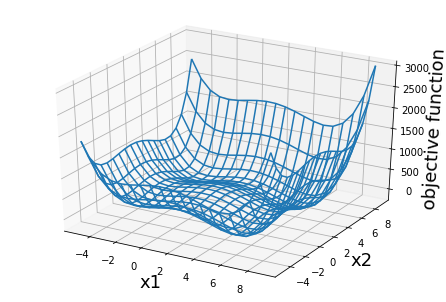

In [4]:
fig = plt.figure()
ax = Axes3D(fig)

ax.set_xlabel("x1", fontsize=18)
ax.set_ylabel("x2", fontsize=18)
ax.set_zlabel("objective function", fontsize=18)



ax.plot_wireframe(x1, x2, y_plot)

In [5]:
from scipy.optimize import minimize
import math

banana = lambda x: (-4*(x[0]**2-16)*(x[0]+4) + ((x[0]**3+x[0]**2)*(x[0]-4)) + ((x[0]+4)**2)*(x[0]-4)) + (-4*(x[1]**2-16)*(x[1]+4) + ((x[1]**3+x[1]**2)*(x[1]-4)) + ((x[1]+4)**2)*(x[1]-4))
sol = minimize(banana, [5,5], bounds=((-5,10), (-5,10)), method='Nelder-Mead')
print(sol)


 final_simplex: (array([[5.5516371 , 5.55163956],
       [5.5516929 , 5.55170066],
       [5.55172877, 5.55160641]]), array([-222.7388694 , -222.73886934, -222.73886897]))
           fun: -222.73886939780647
       message: 'Optimization terminated successfully.'
          nfev: 60
           nit: 31
        status: 0
       success: True
             x: array([5.5516371 , 5.55163956])


C:\Users\Adachi Takashi\Anaconda3\lib\site-packages\scipy\optimize\_minimize.py:516: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  RuntimeWarning)


In [14]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as LN
import networkx as nx
import copy
from scipy.optimize import minimize
# ========================================================================================================================== #
#コード作成の順番
"""
1: Agent_subgrad(object)のclassを作る
2: 各パラメータの値を決定
3: agentの関数の決定．
4: 固定連結無向グラフを作成・プロット
5: 重み行列の決定
6: Initialization
7: Plot the initial estimation
8: アルゴリズムの構築
9: グラフのプロット
10: 収束しているかの確認

目的関数
    F(z) = F_1(z) + F_2(z) + F_3(z)
"""
# ========================================================================================================================== #
#classの設定
class Agent_gradient(object):
    #def __init__() : エージェントの勾配に必要な，変数をAgent_gradient classが持つself変数に代入する
    def __init__(self, N: int, n: int, weight: np.array, name: int, stepsize: float, eventtrigger: float):
        self.N = N #agentの数
        self.n = n #agentの持つ変数の次元
        self.name = name
        self.weight = weight
        self.stepsize = stepsize
        self.eventtrigger = eventtrigger
        
        self.initial_state()

    #Initialization : agentの初期状態を決定する
    def initial_state(self):
        """
        Args:
            self.z_i (np.array) : エージェントの決定変数
            self.z (np.array) : 自身含むほかのエージェントの状態変数
            self.z_send (np.array) : ほかのエージェントに送った自身の状態変数
        """
        self.z_i = np.array([np.random.uniform(2, 6), np.random.uniform(0,3)]) #agentのcost functionの決定変数 (2,6) (1,4)
        self.z = np.zeros([self.N, self.n])
        self.z_send = np.zeros([self.N, self.n])
        
    #Compute the gradient 非凸での勾配を考える．
    def grad(self, i: int, x: np.array, rou=0.01) -> np.array:
        """agent毎の勾配
        Args:
            x (np.array) : 決定変数
            i (int)      : エージェント
        Return:
            各エージェントの勾配
        """
        grad = np.zeros(2)
        if i==0:
            if x[0] >= 8:
                grad[0] = -4*(3*x[0]**2+8*x[0]-16) + rou/self.n*(2*(x[0]-8))
            elif 0 <= x[0] < 8:     
                grad[0] = -4*(3*x[0]**2+8*x[0]-16)
            elif x[0] < 0:
                grad[0] = -4*(3*x[0]**2+8*x[0]-16) + rou/self.n*(2*x[0])
            if x[1] >= 8:
                grad[1] = 3*x[1]**2+8*x[1]-16 + rou/self.n*(2*(x[1]-8))
            elif 0 <= x[1] < 8:     
                grad[1] = 3*x[1]**2+8*x[1]-16
            elif x[1] < 0:
                grad[1] = 3*x[1]**2+8*x[1]-16 + rou/self.n*(2*x[1])
        elif i==1:
            if x[0] >= 8:
                grad[0] = 4*x[0]**3-9*x[0]**2-8*x[0] + rou/self.n*2*(x[0]-8)
            elif 0 <= x[0] < 8:
                grad[0] = 4*x[0]**3-9*x[0]**2-8*x[0]
            elif x[0] < 0:
                grad[0] = 4*x[0]**3-9*x[0]**2-8*x[0] + rou/self.n*2*x[0]
            if x[1] >= 8:
                grad[1] = -4*(3*x[1]**2+8*x[1]-16) + rou/self.n*2*(x[1]-8)
            elif 0 <= x[1] < 8:     
                grad[1] = -4*(3*x[1]**2+8*x[1]-16)
            elif x[1] < 0:
                grad[1] = -4*(3*x[1]**2+8*x[1]-16) + rou/self.n*2*x[1]
        elif i==2:
            if x[0] >= 8:
                grad[0] = 3*x[0]**2+8*x[0]-16 + rou/self.n*2*(x[0]-8)
            elif 0 <= x[0] < 8:
                grad[0] = 3*x[0]**2+8*x[0]-16
            elif x[0] < 0:
                grad[0] = 3*x[0]**2+8*x[0]-16 + rou/self.n*2*x[0]
            if x[1] >= 8:
                grad[1] = 4*x[1]**3-9*x[1]**2-8*x[1] + rou/self.n*2*(x[1]-8)
            elif 0 <= x[1] < 8:
                grad[1] = 4*x[1]**3-9*x[1]**2-8*x[1]
            elif x[1] < 0:
                grad[1] = 4*x[1]**3-9*x[1]**2-8*x[1] + rou/self.n*2*(x[1])
        return grad
    
    #Compute the step-size
    def step_size(self, t, stepsize):
        return stepsize / (t+1)

    #Send the state to the neighbor agents　
    def send(self, j):
        self.z_send[j] = self.z_i
        return self.z_i, self.name
    
    #Receive the states from the neighbor agents
    def receive(self, z_j, name):
        self.z[name] = z_j
        
    #Compute the event_trigger_figure(閾値) eventtrigger / (t+1)
    def event_trigger(self, t, eventrigger):
        return eventrigger / (t + 1)
    
    #Update the state by the distributed subgradient algorithm
    def update(self, t):
        self.diff = self.z - self.z_send
        #noise なし
        self.z_i = self.z_i + np.dot(self.weight, self.diff)  - self.step_size(t, self.stepsize) * self.grad(i=self.name, x=self.z_i)
        #noise　アリ
        #self.z_i = self.z_i + np.dot(self.weight, self.diff)  - self.step_size(t, self.stepsize) * self.grad(i=self.name, x=self.z_i) - self.step_size(t, self.stepsize) * np.random.randn()
        #project range_X
        if not(0<=np.any(Agents[i].z_i)<=8):
             Agents[i].project()
        self.z_send[self.name] = self.z_i
        self.z[self.name] = self.z_i
# ========================================================================================================================== #
#objective function for problem in this simulation    
def objective_function(x: np.array):
    return (-4*(x[0]**2-16)*(x[0]+4) + ((x[0]**3+x[0]**2)*(x[0]-4)) + ((x[0]+4)**2)*(x[0]-4))\
            + (-4*(x[1]**2-16)*(x[1]+4) + ((x[1]**3+x[1]**2)*(x[1]-4)) + ((x[1]+4)**2)*(x[1]-4))
# ========================================================================================================================== #
#Parameters
#Number of agents
N = 3

#Number of dimensions of the decision variable
n = 2

#Coefficient of decision of stepsize : a(t) = a / t
stepsize = 0.0078
        
# Coefficient of the edge weight  w_if = wc / max_degree
wc = 0.8

#Number of iterations
iteration = 10000

# Interval for figure plot 
fig_interval = 200

# plot region
x_min = -6
x_max = 6

#Coefficient of decision of stepsize : E_ij(t) = E(t) = eventtrigger / (t+1)
eventtrigger = [0, 1, 10]

# Randomization seed
np.random.seed(15) #20

# ========================================================================================================================== #
# Communication Graph
A = np.array(
    [[1, 1, 1],
     [1, 1, 0],
     [1, 0, 1]])

G = nx.from_numpy_matrix(A)

# Weighted Stochastic Matrix P
a = np.zeros(N)

for i in range(N):
    a[i] = copy.copy(wc / nx.degree(G)[i])

P = np.zeros((N, N))
for i in range(N):
    for j in range(i, N):
        if i != j and A[i][j] == 1:
            a_ij = min(a[i], a[j])
            P[i][j] = copy.copy(a_ij)
            P[j][i] = copy.copy(a_ij)

for i in range(N):
    sum = 0.0
    for j in range(N):
        sum += P[i][j]
    P[i][i] = 1.0 - sum
# ========================================================================================================================== #
#Agentsの初期状態を統一する
Agent_array = []
initial_state_array = []
for i in range(N):
    Agent_array.append(Agent_gradient(N, n, P[i], i, stepsize, eventtrigger))
    initial_state_array.append(Agent_array[i].z_i)

#初期状態を表示したい場合
print('At initial time:')
for i in range(len(initial_state_array)):
    print('state of agent{} : {}'.format(i, initial_state_array[i]))

#plot時の評価指標に用いる配列
tmp_diff_estim_array = [[], [], []] #Agentの見積もり状態をいれる配列
tmp_diff_consensus_x = [[], [], []]
    
#Algorithm 
for e in range(len(eventtrigger)): #eventtigger と　stepsize の行列から要素を指定
    #initialization
    Agents = copy.deepcopy(Agent_array)
    
    count = 0
    
    z0 = [np.linspace(x_min, x_max) for i in range(N)]

    print('E =', Agents[0].eventtrigger[e])
    
    for i in range(N):
        for j in range(N):
            if i != j and A[i][j] == 1:
                #Send the state to the neighbor agents at initial time 
                state, name = Agents[i].send(j)

                #Receive the state from the neighbor agents at initial time
                Agents[j].receive(state, name)

    for t in range(iteration):    
        sum_diff_fun_at_t = 0
        for agent in Agents:
            sum_diff_fun_at_t += np.abs(objective_function(agent.z_i) - sol.fun)   
        #各エージェントが推定する目的関数のt時刻での誤差の総和
        tmp_diff_estim_array[e].append(sum_diff_fun_at_t)
        
        # ========================================================================================================================== #
        # Transfer data among agents
        for i in range(N):
            for j in range(N):
                if i != j and A[i][j] == 1:
                    if LN.norm(Agents[i].z_i - Agents[i].z_send[j], ord=1) > Agents[i].event_trigger(t+1, Agents[i].eventtrigger[e]):
                        count += 1
                        #Send the state to the neighbor agents
                        state, name = Agents[i].send(j)
                        #Receive the state from the neighbor agents
                        Agents[j].receive(state, name)
        
        # Update the state
        for i in range(N):
            Agents[i].update(t+1)
        
    print('Agents condition after iteration')
    for i in range(N):
        print('Agents', i, Agents[i].z_i)

    tmp_local_minima = sol
        
    print('objective function : {}'.format(tmp_local_minima.fun))

    print('objective function estimated by Agent | 1:{}, 2:{}, 3:{}'.format(objective_function(Agents[0].z_i), objective_function(Agents[1].z_i), objective_function(Agents[2].z_i)))
    
    diff = 0 
    
    for agent in Agents:
        diff += np.abs(tmp_local_minima.fun-objective_function(agent.z_i))
    
    print('count : {}'.format(count))
    print('difference : {}'.format(diff))

At initial time:
state of agent0 : [5.39527079 0.53668777]
state of agent1 : [2.21745286 1.08461534]
state of agent2 : [3.10160371 1.59000067]
E = 0
Agents condition after iteration
Agents 0 [5.68536534 1.11061261]
Agents 1 [5.68383646 1.11055371]
Agents 2 [5.68489656 1.11066322]
objective function : -222.73886939780647
objective function estimated by Agent | 1:108.77907527772106, 2:108.74995209964018, 3:108.76981520365933
count : 39996
difference : 994.5154507744401
E = 1
Agents condition after iteration
Agents 0 [5.68537648 1.11213575]
Agents 1 [5.68384941 1.1120841 ]
Agents 2 [5.68492604 1.11223967]
objective function : -222.73886939780647
objective function estimated by Agent | 1:108.77273204973486, 2:108.74361460188643, 3:108.76358809322718
count : 5167
difference : 994.4965429382679
E = 10
Agents condition after iteration
Agents 0 [5.67439109 1.06159504]
Agents 1 [5.67223917 1.0611339 ]
Agents 2 [5.67331398 1.06159717]
objective function : -222.73886939780647
objective function e

C:\Users\Adachi Takashi\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


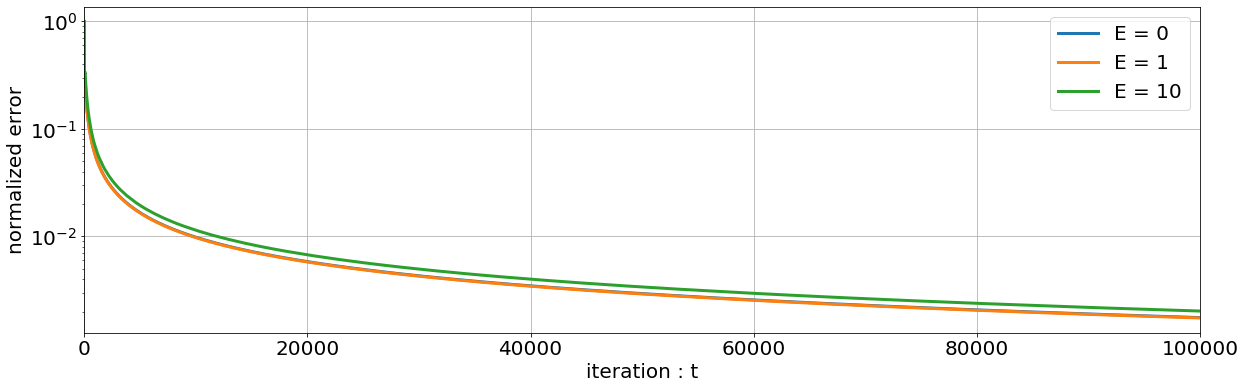

In [7]:
initial_object_state_diff = 0
for t in initial_state_array:
    initial_object_state_diff += np.abs(objective_function(t) - sol.fun)

# グラフの大きさを指定
plt.figure(figsize=(20, 6))
num_iteration = [i for i in range(iteration)]
# label= と　legendでラベルを付ける
for i in range(3):
    plt.plot(num_iteration, tmp_diff_estim_array[i]/initial_object_state_diff,linewidth=3 , label='E = {}'.format(eventtrigger[i]))
plt.legend(fontsize=20)

plt.xlim(0,100000)

plt.yscale('log')

plt.xlabel('iteration : t', fontsize=20)
plt.ylabel('normalized error', fontsize=20)
plt.axis(linewidth=30)
plt.grid(True)
plt.tick_params(labelsize=20)

plt.show()

In [8]:
print(tmp_diff_estim_array[0][-1]/initial_object_state_diff)
print(tmp_diff_estim_array[1][-1]/initial_object_state_diff)
print(tmp_diff_estim_array[2][-1]/initial_object_state_diff)

0.0017569326317873298
0.0017426011963172067
0.002021140206739433
